# City Classifications

- Alexandre Brito NUSP: 11857323
- Eduardo Amaral NUSP: 11735021
- Pedro Liduino NUSP: 11796847
- Ramon Machado NUSP: 12543179
- Vítor Fróis NUSP: 12543440



### Imports

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import contextily as cx

from street_continuity import StreetContinuity
from search_information import SearchInformation

#### Utils

In [2]:
def get_biggest_component(G):
  G = G.to_undirected()
  G.remove_edges_from(nx.selfloop_edges(G))
  Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gcc[0])
  return G

In [3]:
def getShannonEntropy(x):
  degValues, Pdeg = degreeDistribution(x)
  H = 0
  for p in Pdeg:
    if(p > 0):
      H = H - p * np.log2(p)
  return H

def get_biggest_component(G):
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    return G

In [4]:
def degreeDistribution(x):
  maxDeg = np.max(x)
  degValues = np.arange(0,maxDeg+1)
  Pdeg = np.zeros(maxDeg+1)
  for deg in x:
    Pdeg[deg] += 1
  Pdeg /= np.sum(Pdeg)
  return degValues, Pdeg

# Navigation in Cities

### Search Information

We want to compair the **navegability** in networks. In order to do this, we will implement an measure called Search Information presented in the paper [Hide and seek on complex networks](https://arxiv.org/pdf/cond-mat/0407055.pdf).

$S(i → b)=-log2 ∑ P{p(i, b)}$

> Search information $S (i → b)$ measures your ability to locate node $b$ from node $i$.

The hipotesis here is that the **topology** will interfere in the **Search Information** in these networks.

Let's see.

Creating 3 networks

In [5]:
N = 500
av_degree = k = 10
p = 0.05

In [6]:
m = int(av_degree/2)
GBA = nx.barabasi_albert_graph(N, m)

In [7]:
GER = nx.erdos_renyi_graph(N, p)

In [8]:
GWS = nx.watts_strogatz_graph(N, k, p, seed=None)

In [9]:
#get the biggest component to avoid infinity distances
GBA = get_biggest_component(GBA)
GBA = nx.convert_node_labels_to_integers(GBA)
len(GBA)

500

In [10]:
#get the biggest component to avoid infinity distances
GER = get_biggest_component(GER)
GER = nx.convert_node_labels_to_integers(GER)
len(GER)

500

In [11]:
#get the biggest component to avoid infinity distances
GWS = get_biggest_component(GWS)
GWS = nx.convert_node_labels_to_integers(GWS)
len(GWS)

500

This function computes all shortest paths between each pair of nodes in the network and computes the probability to follow these paths.
<br>

For example:

Starting from **node 1** to go to *node 3*, the possible shortest paths are:

[1, 2, 3]

[1, 4, 3]

<br>

Let's consider the following degrees

$k_1 = 3$

$k_2 = 2$

$k_4 = 3$

<br>

Then, starting in node 1, the probability to follow the first path is:

$1 \rightarrow 2 , P = 1/3$

$2 \rightarrow 3 , P = 1/2$

$(1/3)*(1/2) = 1/6$ is the Probability to follow the first path

<br>

Similarly, the probability to follow the second path is:

$1 \rightarrow 4 , P = 1/3$

$4 \rightarrow 3 , P = 1/3$

($1/3)*(1/2) = 1/9$ is the Probability to follow the second path

<br>

So, the Total probability (TP) to follow anyone of the shortest paths is:

$TP = 1/6 + 1/9 = 5/18$

<br>

The function returns a matrix where each element $TP_{ij}$, contains the Total Probability of going from $i$ to $j$.


### Using the library

`from search_information import SearchInformation` import library

`si = SearchInformation(graph)` instantiates the function

`si.get_average_search_information()` compute and get Average Search Information for the graph

`si.get_probability_shortest_path_matrix()` you can also get the Probability of Shortest Paths Matrix

**Run it for a simple network:**

In [12]:
N = 5
G = nx.Graph()
G.add_nodes_from([1, N])
edges = (1,list(range(2, N + 1)))
for k in range(2,N+1):
  G.add_edge(1,k)

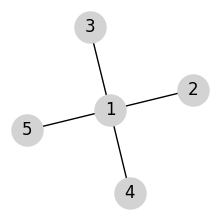

In [13]:
plt.figure(figsize=(2,2))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color="lightgray", node_size=500, with_labels=True)

In [14]:
G_si = SearchInformation(G)

In [15]:
G_average_S = G_si.get_average_search_information()
G_average_S

1.33437600046154

Run it for all the 3 networks

In [16]:
GBA_si = SearchInformation(GBA)
GER_si = SearchInformation(GER)
GWS_si = SearchInformation(GWS)

In [17]:
GBA_average_S = GBA_si.get_average_search_information()
GER_average_S = GER_si.get_average_search_information()
GWS_average_S = GWS_si.get_average_search_information()

In [18]:
GBA_average_S

11.939322016319311

In [19]:
GER_average_S

13.098745385413139

In [20]:
GWS_average_S

15.397750080711395

**Comparing the results:**

The bigger the **Average Search Information** the bigger the information needed to navegate in the network. It's worth mentioning that this measure grows in log2, so a small change means a lot.


**Barabasi Albert**

In this case, **Barabasi Albert** has the smaller **Seach Information**. This makes sense if you consider that this network contains **HUBS**, that is, nodes with many connections, which in this case can be interpreted as **important avenues** that have intersections with several streets, which facilitates navigation through the graph.

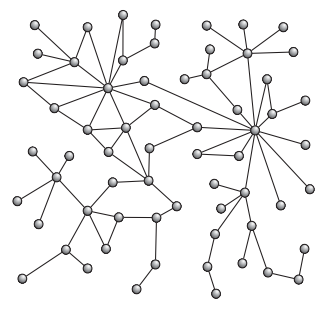

Source: Characterization of complex networks: A survey of measurements

**Erdős–Rényi**

The second smallest is the **Erdős–Rényi** network, which due to its random nature, it makes sense that the topology neither hinders nor facilitates navigation between nodes, resulting in a **Search Information** greater than that of barabasi albert, and smaller than that of small world

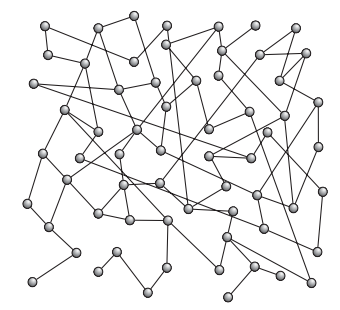

Source: Characterization of complex networks: A survey of measurements

**Watts and Strogatz**

The one with the biggest **Search Information** is **Watts and Strogatz**. It makes sense that its **Search Information** is bigger than the previously mentioned ones, because we use **p = 0.05**, and for p close to 0 the network is regular, with many triangles and large distances. Which in this case can be interpreted as neighborhoods that are very connected to each other, and there is a certain difficulty in leaving this neighborhood to reach another.

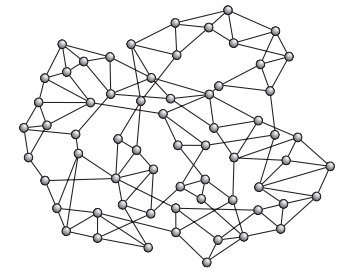

Source: [Characterization of complex networks: A survey of measurements](https://arxiv.org/abs/cond-mat/0505185)

**Small World** with **p = 0.95** to verify it´s search information:

In [21]:
GWS_p95 = nx.watts_strogatz_graph(N, k, 0.95, seed=None)

In [22]:
#get the biggest component to avoid infinity distances
GWS_p95 = get_biggest_component(GWS_p95)
GWS_p95 = nx.convert_node_labels_to_integers(GWS_p95)
len(GWS_p95)

5

In [23]:
GWS_p95_si = SearchInformation(GWS_p95)
GWS_p95_si.get_probability_shortest_path_matrix()

array([[1.        , 0.08333333, 0.08333333, 0.08333333, 0.08333333],
       [0.08333333, 1.        , 0.08333333, 0.08333333, 0.08333333],
       [0.08333333, 0.08333333, 1.        , 0.08333333, 0.08333333],
       [0.08333333, 0.08333333, 0.08333333, 1.        , 0.08333333],
       [0.08333333, 0.08333333, 0.08333333, 0.08333333, 1.        ]])

In [24]:
GWS_p95_prob_shortest_path = GWS_p95_si.get_average_search_information()
GWS_p95_prob_shortest_path

2.8679700005769244

We can see that **Search information** has **decreased** considerably, which makes sense since for p ~ 1, it becomes a random network, with small
distances and few triangles.

# Real Cities Analysis

Of course, after implementing the measure, we want to test it on a Real City Network. With this purpose we can use the library OSMNX, which provides graphs of maps from Open Street Maps

In [25]:
place = 'Cidade Jardim, São Carlos, São Paulo, Brazil'
G = (ox.graph_from_place(place))
G = ox.get_undirected(ox.projection.project_graph(G))

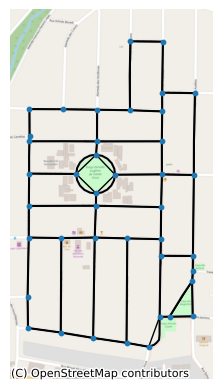

In [26]:
nodes, streets  = ox.graph_to_gdfs(G)
ax = streets.plot(color="k")

nx.draw(
    G, {idx: [data['x'], data['y']] for idx, data in list(G.nodes(data=True))},ax=ax, node_size=10
)

cx.add_basemap(ax, crs=streets.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.axis("off")
plt.show()

Altough this graph looks very interesting, it does not have much utility. The main components of a graph are nodes and edges, which should represent important things we want to map. The corners of a city does not represent important information.

This said, we should represent the fetch graph, called **Primal Graph**, as a **Dual Graph**. The base process is kind of simple: transform nodes into edges and edges into nodes. But, we want to remap all street edges of the primal graph as a single node that represents the whole street.

The function is implemented in a different file, called `street_continuity.py()`

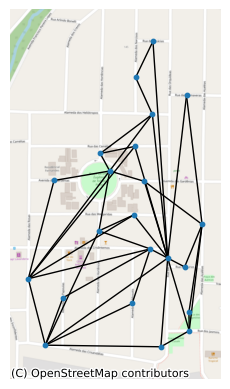

In [27]:
nG = StreetContinuity.get_dual_graph(G)

fig, ax = plt.subplots()

nx.draw(
    nG, {idx: [data['x'], data['y']] for idx, data in list(nG.nodes(data=True))},ax=ax, node_size=10
)
cx.add_basemap(ax, crs=G.graph['crs'], source=cx.providers.OpenStreetMap.Mapnik)
ax.axis("off")

plt.show()

There is one more problem to use this measure: it takes excessive computational power. To deal with this, let's see what Random Graphs best mimic Real Graphs

In [28]:
bairros = [
    'Grajaú',
    'Capão Redondo',
    'República',
    'Jardim Ângela',
    'Centro',
    'Sé',
    'São Mateus',
    
    'Butantã',
    'Moema',
    'Higienópolis',
    'Itaim Bibi',
    'Pinheiros',
    'Perdizes'
]

In [29]:
graph_list = []
avg_list = []
stats = {}
for bairro in bairros:
    place = [f'{bairro}, São Paulo, Brazil']
    G = ox.graph_from_place(place, network_type='drive', which_result=1)
    G = ox.get_undirected(ox.projection.project_graph(G))
    dual_graph = StreetContinuity.get_dual_graph(G)
    graph_list.append((bairro, dual_graph))

In [30]:
from graph_compare import GraphCompare

Evaluating Grajaú: 2609


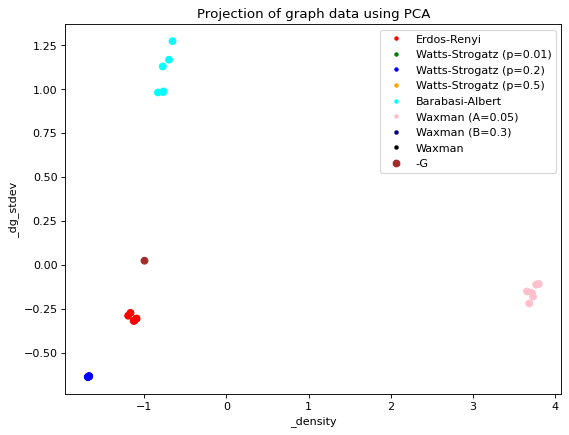

Graph -G is similar to a. Erdos-Renyi (KNN = 3)
Evaluating Capão Redondo: 1631


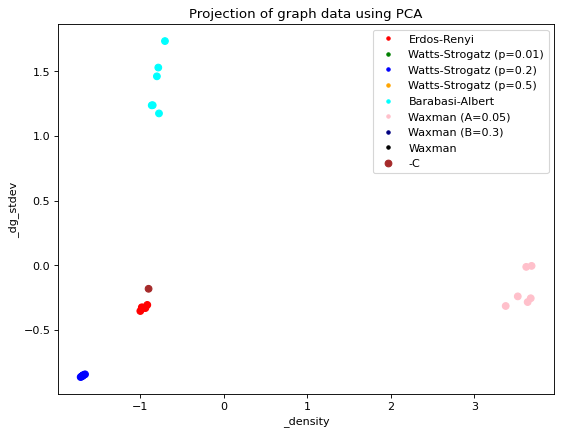

Graph -C is similar to a. Erdos-Renyi (KNN = 3)
Evaluating República: 470


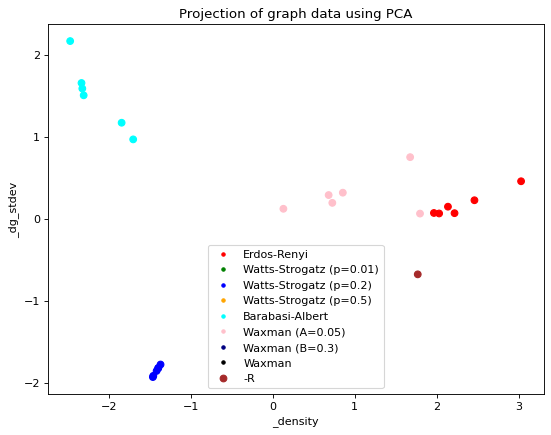

Graph -R is similar to a. Erdos-Renyi (KNN = 3)
Evaluating Jardim Ângela: 1824


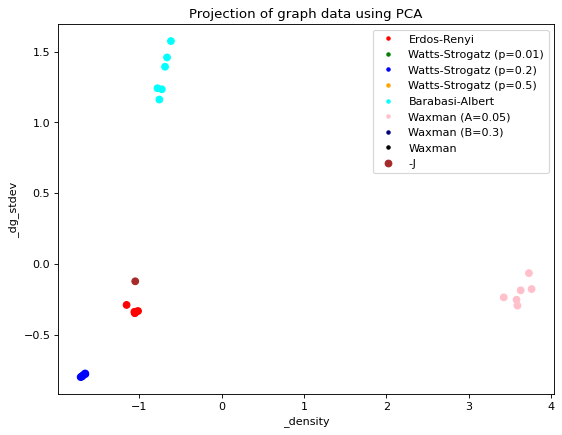

Graph -J is similar to a. Erdos-Renyi (KNN = 3)
Evaluating Centro: 393


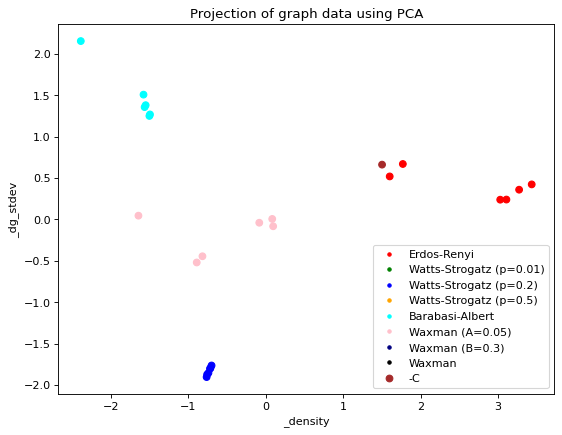

Graph -C is similar to a. Erdos-Renyi (KNN = 3)
Evaluating Sé: 385


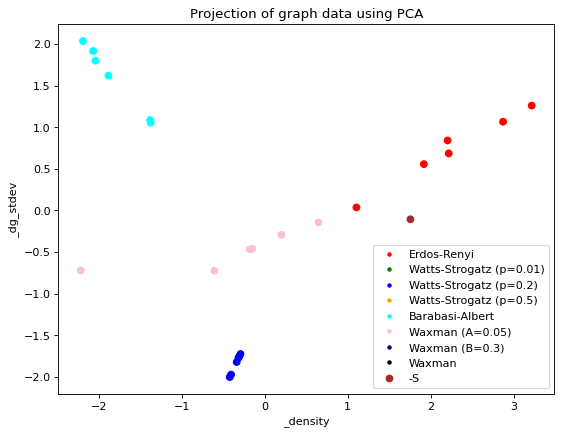

Graph -S is similar to a. Erdos-Renyi (KNN = 3)
Evaluating São Mateus: 1188


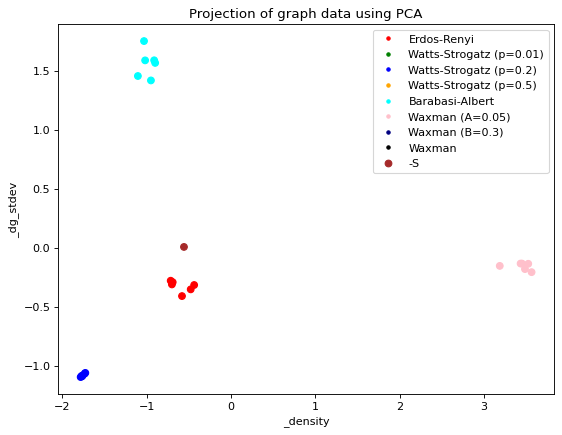

Graph -S is similar to a. Erdos-Renyi (KNN = 3)
Evaluating Butantã: 1080


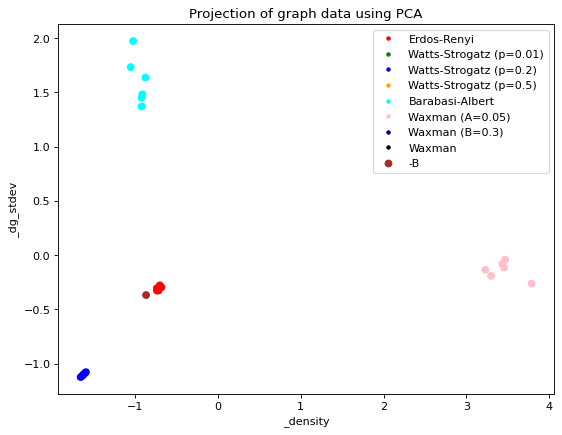

Graph -B is similar to a. Erdos-Renyi (KNN = 3)
Evaluating Moema: 1032


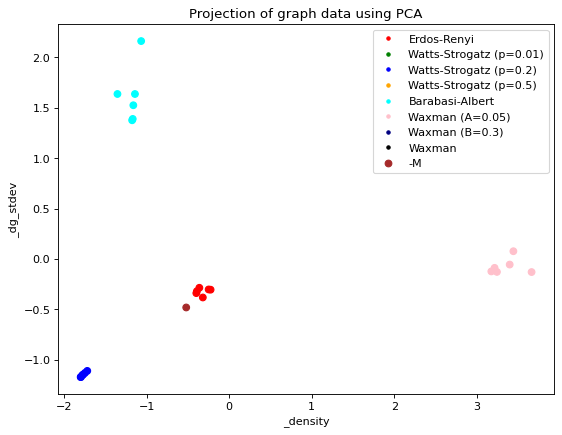

Graph -M is similar to a. Erdos-Renyi (KNN = 3)
Evaluating Higienópolis: 38


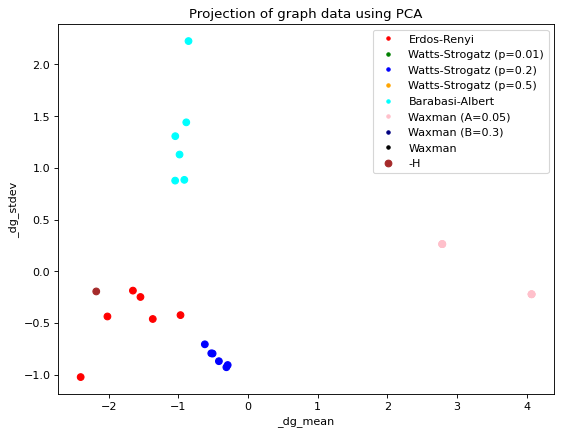

Graph -H is similar to a. Erdos-Renyi (KNN = 3)
Evaluating Itaim Bibi: 1222


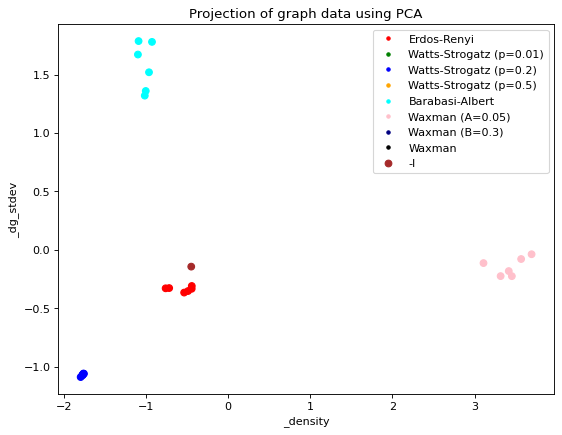

Graph -I is similar to a. Erdos-Renyi (KNN = 3)
Evaluating Pinheiros: 85


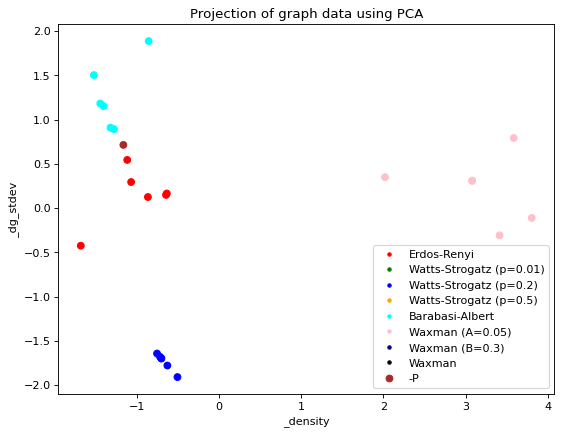

Graph -P is similar to e. Barabasi-Albert (KNN = 3)
Evaluating Perdizes: 674


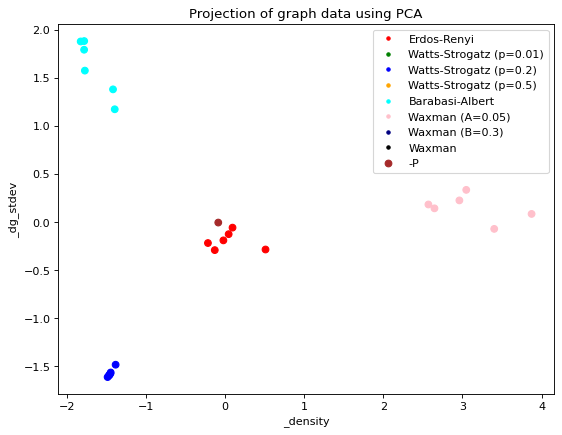

Graph -P is similar to a. Erdos-Renyi (KNN = 3)


In [31]:
for place, graph in graph_list:
    print(f'Evaluating {place}: {len(graph.nodes())}')
    graph_compare = GraphCompare(graph, f"-{place[0]}", "cidade")
    graph_compare.make_pca()
    graph_compare.plot_pca()
    graph_compare.make_knn()

Here, we can see that Erdos Renyi model has the best approach to represent a city dual graph

Let's visualize one real graph

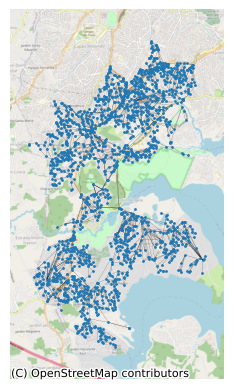

In [32]:
_, graph_to_draw = graph_list[3]

fig, ax = plt.subplots()

nx.draw(
    graph_to_draw, 
    {idx: [data['x'], data['y']] for idx, data in list(graph_to_draw.nodes(data=True))},
    ax=ax, node_size=1, width=0.1
)
cx.add_basemap(ax, crs=G.graph['crs'], source=cx.providers.OpenStreetMap.Mapnik)
ax.axis("off")

plt.show()

Now that we know what random graph best represents city graphs, we can compute Search Information and other measures to discover what measure represents Search Information better

In [106]:
from graph_compare import create_df, Graph

list_si = []

er_graph_list = []
for i in range(100, 600, 5):
    
    er = nx.erdos_renyi_graph(i, 0.002)
    er_graph_list.append(Graph(er, "ER Graph"))
    si = SearchInformation(er)
    avg = si.get_average_search_information()
    list_si.append(avg)
    
list_si /= np.sum(list_si)

df = create_df(er_graph_list) 
df['_search_info'] = list_si

df.drop(['_dg_mean', '_density'], axis=1, inplace=True)

f = (df-df.min())/(df.max()-df.min())

In [107]:
corr_df = df.corr()

In [37]:
si_corr = corr_df['_search_info']
si_corr

name
_dg_stdev           0.575499
_dg_median          0.472668
_shannon_entropy    0.759452
_search_info        1.000000
Name: _search_info, dtype: float64

Shannon entropy has the highest correlation percentage between them all!

In [144]:
from graph_compare import get_var

class_graph_list = []
list_names = []
for place, graph in graph_list:
    list_names.append(place)
    class_graph_list.append(Graph(graph, place, 'Bairro de SP'))

df_bairro = create_df(class_graph_list)
df_bairro['name'] = list_names
df_bairro.reset_index(inplace=True)
df_bairro.drop(['index'], axis=1,inplace=True)

In [145]:
print(df_bairro)

name  _density  _dg_mean _dg_stdev _dg_median _shannon_entropy           name
0     0.001417  3.696435  2.737323        3.0         2.990844         Grajaú
1     0.002425  3.953403  2.197385        4.0         2.960522  Capão Redondo
2     0.010362  4.859574   1.54584        5.0          2.60603      República
3      0.00202  3.682018  2.215188        3.0         2.940684  Jardim Ângela
4     0.011554  4.529262  2.417999        4.0         3.023242         Centro
5     0.011445  4.394805  1.454151        4.0         2.490337             Sé
6       0.0039   4.62963  2.598528        4.0         3.144238     São Mateus
7     0.003817  4.118519  1.876845        4.0         2.769248        Butantã
8     0.004617   4.75969  1.917909        5.0         2.889872          Moema
9     0.135135       5.0  2.336549        5.0         3.099884   Higienópolis
10    0.003863  4.716858  2.519382        5.0         3.141948     Itaim Bibi
11    0.041737  3.505882  2.302295        3.0         2.864609  

Now that we got Shannon Entropy for all Real Graphs, lets get another measure to compare

In [146]:
import os
import pandas as pd

In [147]:
os.listdir()

['graph_compare.py',
 '.git',
 'StreetContinuity',
 'area.csv',
 '.vscode',
 'LICENSE',
 'README.md',
 'density.csv',
 'venv',
 '.ipynb_checkpoints',
 'street_continuity.py',
 'cache',
 'sc',
 'demo_notebooks',
 'main.ipynb',
 'pop.csv',
 '__pycache__',
 'search_information.py',
 'dud.py',
 'viagensAPe.csv',
 'Domicilios_faixa_rendimento_sal_minimos_2010.xls',
 'output',
 'requirements.txt',
 'final.ipynb',
 '.gitignore']

In [148]:
area = pd.read_csv('area.csv')
pop = pd.read_csv('pop.csv', header=2)
viagens = pd.read_csv('viagensAPe.csv')

# pop['area'] = area['Área (km²)']
# pop['pe2'] = viagens['2017']
pop = pop.merge(area, left_on='Local', right_on='Distritos', how='inner')
pop = pop.merge(area, left_on='Local', right_on='Distritos', how='inner')
pop = pop.merge(viagens, left_on='Local', right_on='Subprefeituras', how='inner')

# pop.drop([" Pess/Dom. "], axis=1, inplace=True)
print(pop.columns)
pop['Domicílios'] = pop['Domicílios'].str.replace(' ','')
pop['População'] = pop['População'].str.replace(' ','')
pop['Pe2'] = pop['Pe2'].str.replace(',','')
pop = pop[['Local', 'Domicílios', 'População', 'Area_x', 'Pe2']]
print(pop)
pop['area'] = pop['Area_x'] * 1000000
print(pop)
pop[["Domicílios", "População", "area", "pe2"]] = pop[["Domicílios", "População", "area", "Pe2"]].apply(pd.to_numeric)


pop['pe2_density'] = pop['pe2'] / pop['População']
pop['pop_density'] = pop['População'] / pop['area']

Index(['Local', 'Domicílios', 'População', ' Pess/Dom. ', 'Distritos_x',
       'Area_x', 'Distritos_y', 'Area_y', 'Subprefeituras', 'Pe2'],
      dtype='object')
             Local Domicílios População  Area_x      Pe2
0       Aricanduva      27661     89622    6.96   96664 
1           Carrão      27115     83281    7.90   93761 
2     Vila Formosa      30412     94799    7.47   82090 
3          Butantã     135821    428217   12.95  439584 
4          Butantã     135821    428217   12.95   67121 
..             ...        ...       ...     ...      ...
153  Vila Prudente      80477    246589    9.58  217757 
154  Vila Prudente      80477    246589    9.58  118939 
155  Vila Prudente      34707    104242    9.58  217757 
156  Vila Prudente      34707    104242    9.58  118939 
157      São Lucas      45770    142347    9.67   98818 

[158 rows x 5 columns]
             Local Domicílios População  Area_x      Pe2        area
0       Aricanduva      27661     89622    6.96   96664    6

In [149]:
pop_density = pop[['Local', 'pop_density', 'pe2', 'População']].drop_duplicates(['Local'])

Here we got Demographic Density from all SP suburbans

In [150]:
compare = pop_density.merge(df_bairro, left_on='Local', right_on='name')


Merge both Dataframes

In [151]:
compare.sort_values(by='pop_density')

,Local,pop_density,pe2,População,_density,_dg_mean,_dg_stdev,_dg_median,_shannon_entropy,name
2,Grajaú,0.003892,454599,360787,0.001417,3.696435,2.737323,3.0,2.990844,Grajaú
4,Jardim Ângela,0.007897,340839,295434,0.00202,3.682018,2.215188,3.0,2.940684,Jardim Ângela
10,Moema,0.009181,118092,83368,0.004617,4.75969,1.917909,5.0,2.889872,Moema
6,Itaim Bibi,0.009229,330081,92570,0.003863,4.716858,2.519382,5.0,3.141948,Itaim Bibi
3,Perdizes,0.017533,138904,111161,0.006636,4.465875,2.295326,4.0,3.091501,Perdizes
1,Capão Redondo,0.019516,381737,268729,0.002425,3.953403,2.197385,4.0,2.960522,Capão Redondo
9,República,0.023742,228854,56981,0.010362,4.859574,1.54584,5.0,2.60603,República
0,Butantã,0.033067,439584,428217,0.003817,4.118519,1.876845,4.0,2.769248,Butantã
7,São Mateus,0.033291,548334,426794,0.0039,4.62963,2.598528,4.0,3.144238,São Mateus
5,Pinheiros,0.034825,757692,289743,0.041737,3.505882,2.302295,3.0,2.864609,Pinheiros


In [152]:
compare[['pop_density', '_shannon_entropy']].corr()

,pop_density,_shannon_entropy
pop_density,1.000000,-0.673312
_shannon_entropy,-0.673312,1.000000


Search Information represents the difficult of traveling in a network topology. This relation is **inverse**, that is: the bigger the **difficult of traveling in a neighborhood**, smaller the **demographic density**.

This can be interpreted as a capacity of the neighborhood to **adapt** to the big density coefficient, building its streets in more efficient ways.

### Complexity and Conclusions

The main difficulty of this project was to calculate the Search Information. The algorithm is very complex and takes a lot of computational power.

The group tried to deal with this by finding a similar generated graph model that could better the real graphs. After that, we could calculate the Search Information for smaller graphs and use to find a lighweight measure that could better represent the Search Information. The measure found was Shannon Entropy.

Even tough this is not the ideal/desired way to proceed, we still got some interesting results. The main one is the relation between Search Information (approximated by Shannon Entropy) and Demographic Density.

### Future Work and Alternatives

The main alternative to this project is to find a way to calculate Search Information in a more efficient way. This would allow us to calculate it for all graphs and find a better measure to represent it.

The group thought in two ways to improve the efficiency of the algorithm:

#### 1. Using only one shortest path for each pair of nodes
Currently, the algorithm uses all shortest paths between all pairs of nodes.

We could try to approximate it by using only one shortest path for each pair of nodes.
This could be done using `nx.all_pairs_shortest_path`

The above cited function is faster than the current implementation, but it still is a heavy algorithm.

#### 2. Using the shortest path length instead of the path itself and the average degree of the graph
Calculating the average degree is a ligweight algorithm.

The shortest path lenght between all pairs of nodes can be calculated in a very efficient way using sparse matrixes and `scipy.sparse.csgraph.shortest_path`

After finding the shortest path length between all pairs of nodes, we could use it to calculate the Search Information doing the following:

Instead of doing:
$$
  P[p(s,t)] = \frac{1}{k_s} \prod_{j \in p(s,t)} \frac{1}{k_j - 1}
$$

And then:

$$
  P(s\rightarrow t) = \sum_{p(s,t)} P[p(s,t)]
$$

We could do:

$$
  P(s\rightarrow t) = \frac{1}{avgDegree} * (\frac{1}{avgDegree - 1})^{shortestPathLength - 1}
$$

Where `avgDegree` is the average degree of the graph and `shortestPathLength` is the shortest path length between the pair of nodes.

Both ways could be more efficient than the current implementation, but it is necessary to test the correlation between the new measures and the Search Information to ensure that they are good approximations.

As the Search Information is a very heavy algorithm the group decided to leave the test of these alternatives for future work.